# Ball Tracking with OpenCV

The tracking will be performed as follows:
 - **Step #1**: Detect the presence of a _coloured_ ball using classical computer vision techniques
 - **Step #2**: Track the ball as it moves around in the video frames, drawing its previous postions as it moves

In [14]:
# import necessary packages
from collections import deque # double ended-queue
from imutils.video import VideoStream
import numpy as np
import cv2 
import imutils
import time
import matplotlib.pyplot as plt
%matplotlib inline


Let's define some variables and check out the videostream

In [15]:
video_path = "ball_tracking_example.mp4"
buffer = 64 # number of pervious locations of ball to store in queue

__buffer__  is the maximum size of our _deque_ , which maintains a list of the previous (x, y)-coordinates of the ball we are tracking. This deque  allows us to draw the “contrail” of the ball, detailing its past locations. 
A smaller queue will lead to a shorter tail whereas a larger queue will create a longer tail (since more points are being tracked).

In [16]:
from IPython.display import Video # to diplay video in notebook
Video(video_path, width=320, height=240)

In [17]:
# define the lowe and upper boundries of the "green"
# ball in the HSV(hue, saturation, value) color space, then initialize the 
# list of tracked points
greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)
pts = deque(maxlen=buffer) # define queue of certain size(buffer)

# get the video stream
vs = cv2.VideoCapture(video_path)

# allow the video file to buffer up some frames
time.sleep(2.0)


___Lines 4 and 5 above___ define the lower and upper boundaries of the color green the ball takes on in the HSV color space (which I determined using the range-detector script in the imutils  library). These color boundaries will allow us to detect the green ball in our video file. 

___Line 6 above___ then initializes our deque of pts using the supplied maximum buffer size.

## Let' see how to create a mask that captures only the ball in the image.

First we need to preprocess the image

frame count: 1137.0


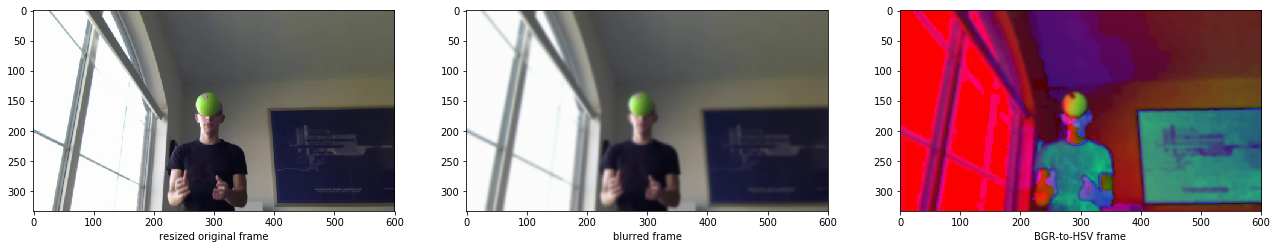

In [35]:
# lets grab an arbitrary frame from the video to
# test our implementation

vid = cv2.VideoCapture(video_path)
num_of_frames = vid.get(cv2.CAP_PROP_FRAME_COUNT)
print("frame count: {}".format(num_of_frames))

# set postion to a frame in the middel of the video
ret = vid.set(cv2.CAP_PROP_POS_FRAMES, int(num_of_frames/2))

# read the frame
fr = vid.read()[1]

frame = imutils.resize(fr, width=600)
blurred = cv2.GaussianBlur(frame, (11,11), 0)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

# lets see how the frame looks afer the above preprcessing
fig, ax = plt.subplots(1,3, figsize=(22,18))
x_ticks = ['resized original frame', 'blurred frame', 'BGR-to-HSV frame']

ax[0].imshow(frame[...,::-1])
ax[0].set_xlabel(x_ticks[0])


ax[1].imshow(blurred[...,::-1])
ax[1].set_xlabel(x_ticks[1])


ax[2].imshow(hsv[...,::-1])
ax[2].set_xlabel(x_ticks[2])

plt.show()

Now lets get the mask

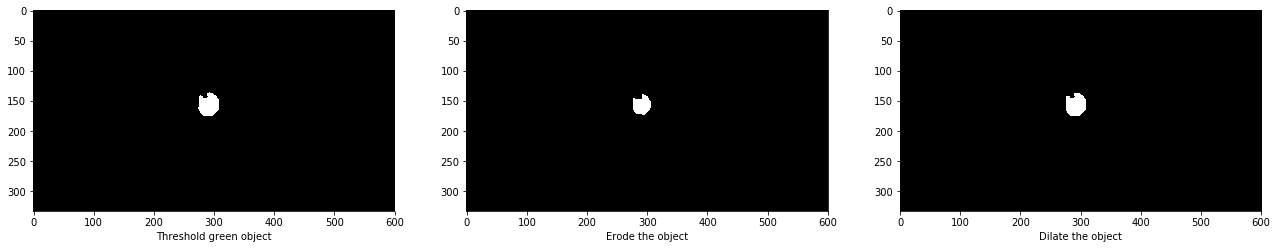

In [36]:
mask_inter_1 = cv2.inRange(hsv, greenLower, greenUpper) # intermediate mask#1, Thresholds image in HSV colorspace 
mask_inter_2 = cv2.erode(mask_inter_1, None, iterations=2) # intermediate mask#2
mask_final = cv2.dilate(mask_inter_2, None, iterations=2) # final mask

fig, ax = plt.subplots(1,3, figsize=(22,18))
x_ticks = ['Threshold green object', 'Erode the object', 'Dilate the object']

ax[0].imshow(mask_inter_1, cmap='gray')
ax[0].set_xlabel(x_ticks[0])


ax[1].imshow(mask_inter_2, cmap='gray')
ax[1].set_xlabel(x_ticks[1])


ax[2].imshow(mask_final, cmap='gray')
ax[2].set_xlabel(x_ticks[2])

plt.show()

## Let's draw a outline the ball in the image

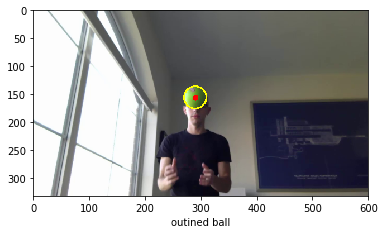

In [37]:
# find all the contours in the image
cnts = cv2.findContours(mask_final.copy(), cv2.RETR_EXTERNAL, 
                           cv2.CHAIN_APPROX_SIMPLE)
cnts= imutils.grab_contours(cnts)

# get the biggest contour 
c = max(cnts, key=cv2.contourArea)

# cerate a minimum enclsing circle around the object
((x,y), radius) = cv2.minEnclosingCircle(c)
M = cv2.moments(c)
center = ( int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]) )
# draw the circel and centroid on the frame,
# then update the list of tracked points
cv2.circle(frame, (int(x), int(y)), int(radius), (0,255,255), 2) # draws outline of ball
cv2.circle(frame, center, 5, (0, 0, 255), -1) # draws center of the ball

plt.imshow(frame[...,::-1])
plt.xlabel('outined ball')
plt.show()

## Putting it all together

In [18]:
from IPython.display import display , Image, clear_output

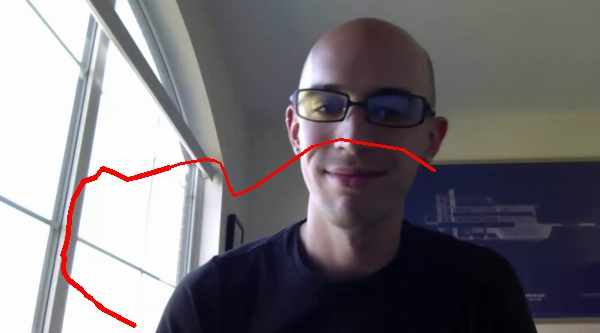

In [19]:
# keep looping over the video frames

while True:
    # grab the current frame
    frame = vs.read() # returns retval, image
    frame = frame[1]#get the image
    # if reached the end of video, break
    if frame is None:
        break
        
    # resize the frame, blur it, and convert it to HSV
    # color space
    frame = imutils.resize(image=frame, width=600) # target width 600, aspect ratio will be maintained automatically
    blurred = cv2.GaussianBlur(src=frame, ksize=(11, 11), sigmaX=0)
    hsv = cv2.cvtColor(src=blurred, code=cv2.COLOR_BGR2HSV)
    
    # construct a mask for the "green" object and perform
    # a series of dilation and erosion to remove any small
    # blobs left in the mask
    mask = cv2.inRange(src=hsv, lowerb=greenLower, upperb=greenUpper) # localized ball in a given frame
    mask = cv2.erode(src=mask, kernel=None, iterations=2)
    mask = cv2.dilate(src=mask, kernel=None, iterations=2)
        
    # find the contours in the mask and initialize the current 
    # (x, y) center of the ball
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, 
                           cv2.CHAIN_APPROX_SIMPLE)
    cnts= imutils.grab_contours(cnts)
    
    center = None
    
    # proceed if at least one contour was found 
    if len(cnts) > 0:
        # find the largest contour in the mask, then use
        # it to compute the minimum enclosing circle, and 
        # centroid
        c = max(cnts, key=cv2.contourArea)
        ((x,y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        center = ( int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]) )
        
        # only proceed if radius meets a min size requirement
        if radius > 10:
            # draw the circel and centroid on the frame,
            # then update the list of tracked points
            cv2.circle(frame, (int(x), int(y)), int(radius), (0,255,255), 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
    
    # update pts queue
    pts.appendleft(center)
    
    # now simple draw the outline of the ball and its trail
    
    # loop over the sent of tracked points
    for i in range(1, len(pts)):
        # if either of the tracked points are None, ignore them
        if pts[i -1] is None or pts[i] is None:
            continue
        
        # otherwise, compute the thickness of the line and draw
        # the connecting lines
        thickness = int(np.sqrt(buffer / float(i +1))*2.5)
        cv2.line(frame, pts[i-1], pts[i], (0,0,255), thickness)
        
    # show the frame to our screen    
    #plt.imshow(frame[...,::-1])
    #plt.show()
    
    # for jupyter first we need to save the image then dsplay it 
    # for a video like effect
    cv2.imwrite('pic.jpg', frame) # first we save it
    display(Image("pic.jpg"))
    
    clear_output(wait=True)
    
    